In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

2023-12-28 16:34:41.434059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 16:34:41.434113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 16:34:41.435485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 16:34:41.444853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 16:34:42.486219: W tensorflow/compiler/tf2

In [2]:
att=["cycle","temperature_measured","capacity","current_load"]
dataset[["Soh"]]=dataset[["capacity"]]/dataset["capacity"][0]

In [3]:
Soh=dataset["capacity"]/dataset["capacity"][0]
time=dataset[["time"]]

In [4]:
# normalising data
dataset=dataset[["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load"]]
df_norm = (dataset-dataset.min())/(dataset.max()-dataset.min())
df_norm["time"]=time
df_norm["Soh"]=Soh

In [5]:
att_=["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load","time"]
att=["cycle","temperature_measured","capacity","current_load"]

In [6]:
X = df_norm[att]
Y = df_norm[["Soh"]]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0) 

In [8]:
#sorting data wrt to index
X_test = X_test.sort_index(axis=0)
X_train= X_train.sort_index(axis=0)
y_train= y_train.sort_index(axis=0)
y_test = y_test.sort_index(axis=0)

In [9]:
#define lstm model we have 4 input variable so 3 layers
model = Sequential()
model.add(LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.25))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 4, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 4, 64)             0         
                                                                 
 dense (Dense)               (None, 4, 1)              6

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [11]:
model.fit(X_train, y_train, epochs=200,batch_size=20, verbose=1,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200


1408/1408 [==============================] - 16s 9ms/step - loss: 0.0232 - val_loss: 2.5890e-04
Epoch 2/200
1408/1408 [==============================] - 11s 8ms/step - loss: 0.0032 - val_loss: 8.2998e-04
Epoch 3/200
1408/1408 [==============================] - 11s 8ms/step - loss: 0.0020 - val_loss: 7.7232e-04
Epoch 4/200
1408/1408 [==============================] - 11s 8ms/step - loss: 0.0010 - val_loss: 3.8783e-04
Epoch 5/200
1408/1408 [==============================] - 11s 8ms/step - loss: 4.4963e-04 - val_loss: 3.1376e-04
Epoch 6/200
1408/1408 [==============================] - 11s 8ms/step - loss: 2.2949e-04 - val_loss: 1.1958e-04
Epoch 7/200
1408/1408 [==============================] - 11s 8ms/step - loss: 1.7103e-04 - val_loss: 1.9724e-04
Epoch 8/200
1408/1408 [==============================] - 11s 8ms/step - loss: 1.5554e-04 - val_loss: 3.5567e-04
Epoch 9/200
1408/1408 [==============================] - 11s 8ms/step - loss: 1.4439e-04 - val_loss: 3.0004e-04
Epoch 10/200
1408/14

In [12]:
y_pred_1 = model.predict(X_test, verbose=1)

472/472 [==============================] - 2s 3ms/step


In [13]:
y_pred_1=[ float(sum(i)/4) for i in y_pred_1 ]

/tmp/ipykernel_33797/480392800.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_1=[ float(sum(i)/4) for i in y_pred_1 ]


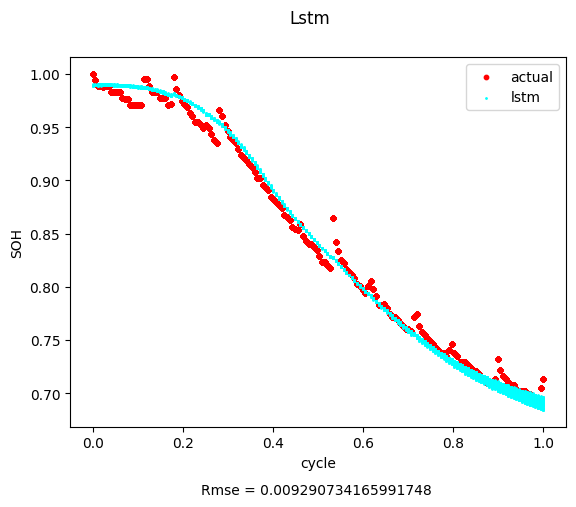

0.009290734165991748


In [14]:
plt.scatter(X_test["cycle"],y_test,color='red',label='actual',s=10)
plt.scatter(X_test["cycle"],y_pred_1,color='cyan',label="lstm",s=1)
plt.xlabel("cycle")
plt.ylabel("SOH")
rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))
plt.figtext(0.33, -0.03, rmse, fontsize=10)
plt.legend(loc="upper right")
plt.suptitle("Lstm")
plt.show()
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))